**Pregunta 4**

In [2]:
import keras
from keras.datasets import cifar100
(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

Using TensorFlow backend.


In [3]:
x_train = x_train.reshape((x_train.shape[0],3,32,32))
x_train = x_train.transpose([0, 2, 3, 1]) #only if 'tf' dim-ordering is to be used
x_test= x_test.reshape((x_test.shape[0],3,32,32))
x_test= x_test.transpose([0, 2, 3, 1])#remove if 'th' dim-ordering is to be used
y_train = keras.utils.to_categorical(y_train, num_classes=100)
y_test = keras.utils.to_categorical(y_test, num_classes=100)
x_train = x_train/255.0
x_test = x_test/255.0

Parte a)

Librerías son importadas.

In [4]:
from keras.models import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout,Activation,BatchNormalization
from keras.optimizers import SGD,Adam
from timeit import default_timer as timer
import numpy as np

Luego se define el modelo.

In [20]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:],activation='relu'))
model.add(Conv2D(32, (3, 3),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3),padding='same',activation='relu'))
model.add(Conv2D(64, (3, 3),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1024,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(100))
model.add(Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4096)              0         
__________

Se define una función para visualizar la pérdida y precisión durante el entrenamiento del modelo.

In [5]:
import matplotlib.pyplot as plt
def resumenGrafico(history):
    if ('acc' in history.history):
        fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15,5))
        ax = axes.flatten()
        ax[0].plot(history.history['loss'])
        ax[0].plot(history.history['val_loss'])
        ax[0].set_title('Perdida del modelo')
        ax[0].set_ylabel('Perdida')
        ax[0].set_xlabel('Epoch')
        ax[0].legend(['Train', 'Val'], loc='upper left')
        ax[1].plot(history.history['acc'])
        ax[1].plot(history.history['val_acc'])
        ax[1].set_title('Precision del modelo')
        ax[1].set_ylabel('Precision')
        ax[1].set_xlabel('Epoch')
        ax[1].legend(['Train', 'Val'], loc='upper left')
    else:
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Perdida del modelo')
        plt.ylabel('Perdida')
        plt.xlabel('Epoch')
        plt.legend(['train', 'test'], loc='upper left')
    plt.show()

Entonces se entrena el modelo y luego se muestran los gráficos correspondientes.

In [21]:
optimizer_ = SGD(lr=0.01,momentum=0.9)
model.compile(loss='categorical_crossentropy', optimizer=optimizer_, metrics=['accuracy'])
start = timer()
historia1=model.fit(x_train, y_train, batch_size=128,epochs=15,verbose=0, validation_data=(x_test,y_test))
end = timer()
print("Tiempo de ejecución: {} seg".format(end - start))

Tiempo de ejecución: 168.52740057400297 seg


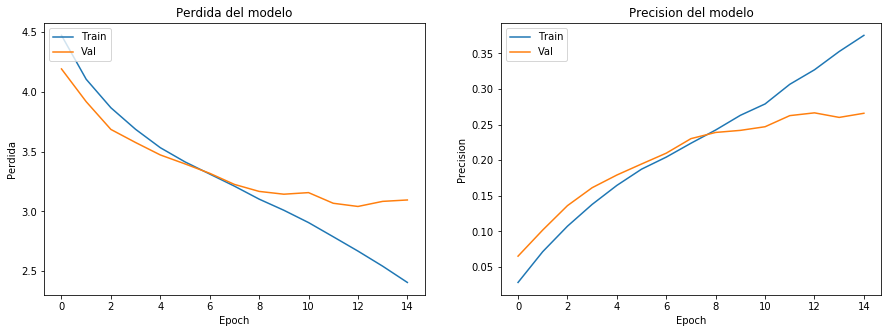

In [22]:
resumenGrafico(historia1)

Como se puede observar, la red neuronal es propensa a overfitting tras aproximadamente 10 epochs, lo que indica que se deben hacer uso de regularizadores.

Parte b)

Se exploran 7 distintas variaciones para la ubicación del dropout.
* Después de la primera tanda de capas convolucionales.
* Después de la segunda tanda de capas convolucionales.
* Después de la primer pooling.
* Después del segundo.
* Tras ambas capas convolucionales.
* Tras ambos poolings.
* En todas las anteriores.

Se procede a entrenar todos estos modelos.

In [16]:
historias=[]
for i in range(7):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:],activation='relu'))
    model.add(Conv2D(32, (3, 3),padding='same',activation='relu'))
    if(i==0 or i==6 or i==4):
        model.add(Dropout(0.25))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    if(i==2 or i==6 or i==5):
        model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3),padding='same',activation='relu'))
    model.add(Conv2D(64, (3, 3),padding='same',activation='relu'))
    if(i==1 or i==6 or i==4):
        model.add(Dropout(0.25))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    if(i==3 or i==6 or i==5):
        model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1024,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(100))
    model.add(Activation('softmax'))
    optimizer_ = SGD(lr=0.01,momentum=0.9)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer_, metrics=['accuracy'])
    start = timer()
    history=model.fit(x_train, y_train, batch_size=128,epochs=15,verbose=0, validation_data=(x_test,y_test))
    historias.append(history)
    end = timer()
    print("Tiempo de ejecución: {} seg".format(end - start))

Tiempo de ejecución: 194.0694785830001 seg
Tiempo de ejecución: 181.8685716710006 seg
Tiempo de ejecución: 174.33081272300115 seg
Tiempo de ejecución: 171.35494282800028 seg
Tiempo de ejecución: 211.0561264049993 seg
Tiempo de ejecución: 179.4229742919997 seg
Tiempo de ejecución: 223.84632589399916 seg


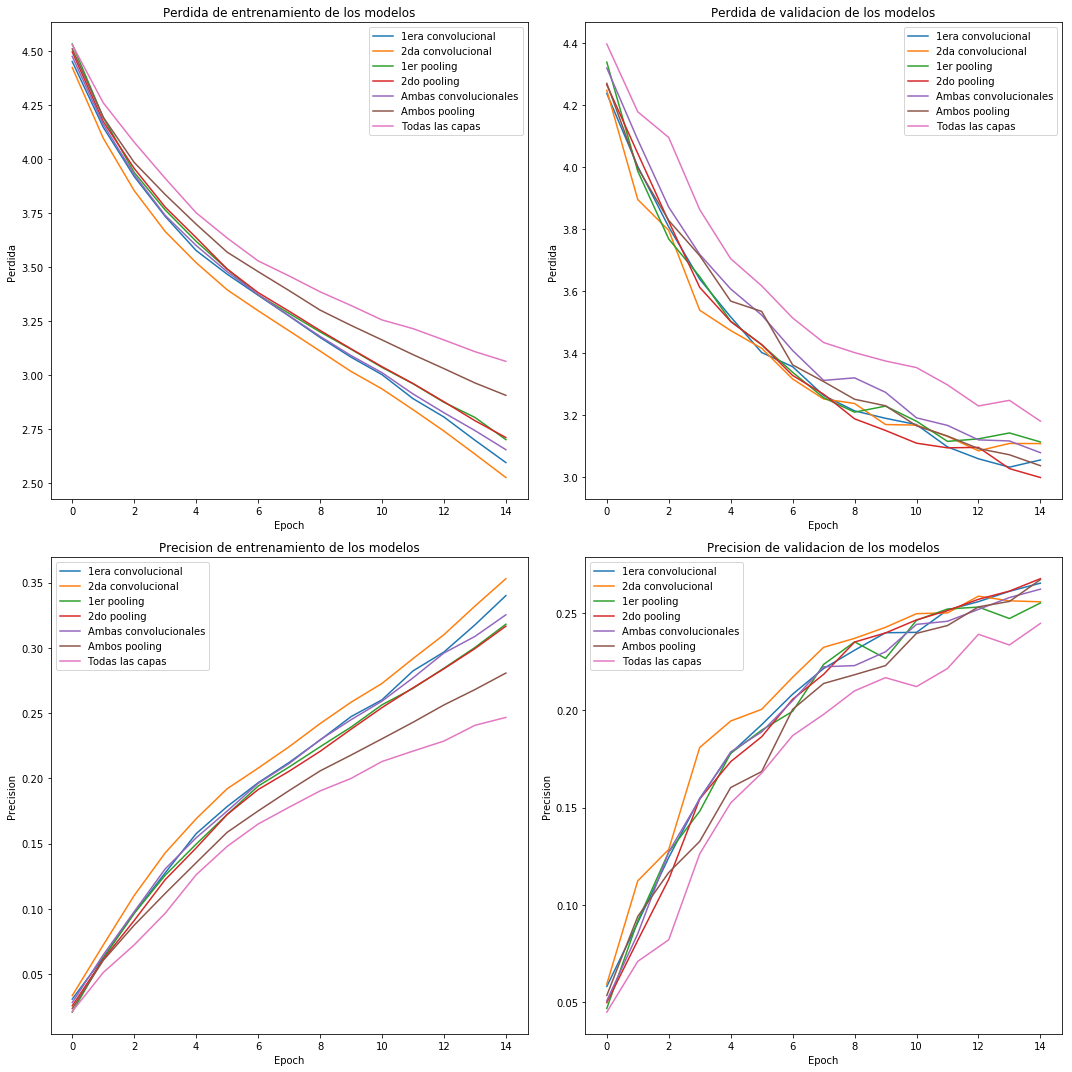

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(15,15))
ax = axes.flatten()
leg=['1era convolucional','2da convolucional','1er pooling','2do pooling','Ambas convolucionales','Ambos pooling','Todas las capas']
for i in range(7):
    ax[0].plot(historias[i].history['loss'])
    ax[1].plot(historias[i].history['val_loss'])
    ax[2].plot(historias[i].history['acc'])
    ax[3].plot(historias[i].history['val_acc'])
ax[0].set_title('Perdida de entrenamiento de los modelos')
ax[0].set_ylabel('Perdida')
ax[0].set_xlabel('Epoch')
ax[0].legend(leg, loc='upper right')
ax[1].set_title('Perdida de validacion de los modelos')
ax[1].set_ylabel('Perdida')
ax[1].set_xlabel('Epoch')
ax[1].legend(leg, loc='upper right')
ax[2].set_title('Precision de entrenamiento de los modelos')
ax[2].set_ylabel('Precision')
ax[2].set_xlabel('Epoch')
ax[2].legend(leg, loc='upper left')
ax[3].set_title('Precision de validacion de los modelos')
ax[3].set_ylabel('Precision')
ax[3].set_xlabel('Epoch')
ax[3].legend(leg, loc='upper left')
plt.tight_layout()
plt.show()

El que mejor se desempeña es el que utiliza dropout directamente bajo la segunda tanda de capas convolucionales.

Se podría argumentar que dado que dropout ignora de manera aleatoria ciertas neuronas, introducirlo en las primeras capas dificulta el aprendizaje (pues estas son las más cercanas al input).

Por otro lado, repetir el dropout significa disponer de menos información a lo largo de toda la red, lo que perjudica el aprendizaje. Esto se puede ver en el modelo donde se aplicó dropout a todas las capas consideradas, el cuál tiene el peor desempeño de todos.

Además, aquellos modelos que ocuparon dropout tras pooling mostraron el peor desempeño respecto a los que no. Esto podría ponerse en paralelo a la analogía de las capas más sensibles; cómo el pooling toma la señal más prominente de un conjunto de neuronas, la capa siguiente es más sensible a aprendizaje y por lo tanto ignorar algunas neuronas termina produciendo una pérdida de información que entorpece a la red neuronal.

Parte c)

Primero se definen las funciones de activación de los autoencoders, al igual que la función de pérdida.

In [12]:
loss_='binary_crossentropy'
activation_1='relu'
activation_2='relu'
decoder_activation='sigmoid'
decoder_activation2='sigmoid'

In [13]:
from keras.layers import Input
from keras.models import Model

Los autoencoders son entrenados.

In [14]:
hidden_layer1=64
hidden_layer2=128

In [16]:
input_img = Input(shape=x_train.shape[1:])
encoded1 = Conv2D(hidden_layer1, (3, 3),activation=activation_1,padding='same')(input_img)
decoded1 = Conv2D(3, (3, 3), activation=decoder_activation, padding='same')(encoded1)
autoencoder1 = Model(input_img, decoded1)
autoencoder1.compile(optimizer='adam', loss=loss_)
autoencoder1.summary()
start=timer()
autoencoder1.fit(x_train, x_train, epochs=15, batch_size=128,validation_data=(x_test, x_test),verbose=0)
end = timer()
print("Tiempo de ejecución autoencoder1: {} seg".format(end - start))
autoencoder1.save('autoencoder_layer1.h5')
###BUILD AUTOENCODER2
encoded1 = autoencoder1.layers[1](autoencoder1.input)
#AUTOENCODER2
encoded2 = Conv2D(hidden_layer2,(3, 3), activation=activation_2, padding='same')(encoded1) 
decoded2 = Conv2D(hidden_layer1,(3, 3), activation=decoder_activation2,padding='same')(encoded2) 
#finish AUTOENCODER2
decoded1 = autoencoder1.layers[-1](decoded2)
autoencoder2 = Model(autoencoder1.input, decoded1) #all model
#autoencoder1 set fixed
autoencoder2.layers[1].trainable=False
autoencoder2.layers[-1].trainable=False
autoencoder2.compile(optimizer='adam', loss=loss_)
autoencoder2.summary()
start=timer()
autoencoder2.fit(x_train, x_train, epochs=10, batch_size=128,validation_data=(x_test, x_test),verbose=0)
end = timer()
print("Tiempo de ejecución autoencoder2: {} seg".format(end - start))
autoencoder2.save('autoencoder_layer2.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 3)         1731      
Total params: 3,523
Trainable params: 3,523
Non-trainable params: 0
_________________________________________________________________
Tiempo de ejecución autoencoder1: 141.02223857199715 seg
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        1792      
_________________

Luego se entrena el modelo indicado en el enunciado. Este proceso se denomina *fine_tuning*, donde se definen los parámetros del modelo que se apoyará en lo aprendido de los modelos anteriores.

In [17]:
model = Sequential()
model.add(Conv2D(hidden_layer1,(3, 3),padding='same',activation=activation_1,input_shape=x_train.shape[1:]))
model.layers[-1].set_weights(autoencoder1.layers[1].get_weights())
model.add(Conv2D(hidden_layer2, (3, 3),padding='same',activation=activation_2))
model.layers[-1].set_weights(autoencoder2.layers[2].get_weights())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3),padding='same',activation='relu'))
model.add(Conv2D(64, (3, 3),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1024,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(100))
model.add(Activation('softmax'))
optimizer_ = keras.optimizers.SGD(lr=0.01,momentum=0.9)
model.compile(loss='categorical_crossentropy', optimizer=optimizer_, metrics=['accuracy'])
start=timer()
historia2=model.fit(x_train, y_train, batch_size=128,epochs=15,verbose=0, validation_data=(x_test, y_test))
end = timer()
print("Tiempo de ejecución: {} seg".format(end - start))

Tiempo de ejecución: 352.0390069310015 seg


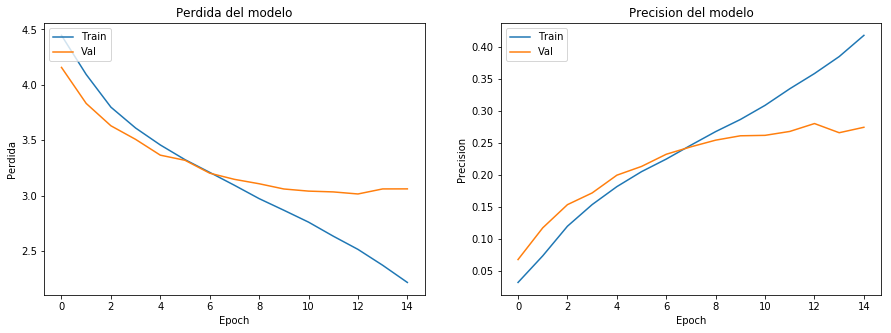

In [18]:
resumenGrafico(historia2)

En contraste con la red original, este modelo sufre de overfitting aún más rápido, ahora a los 6 epochs.

In [23]:
historias=[]
historias.append(historia1)
historias.append(historia2)

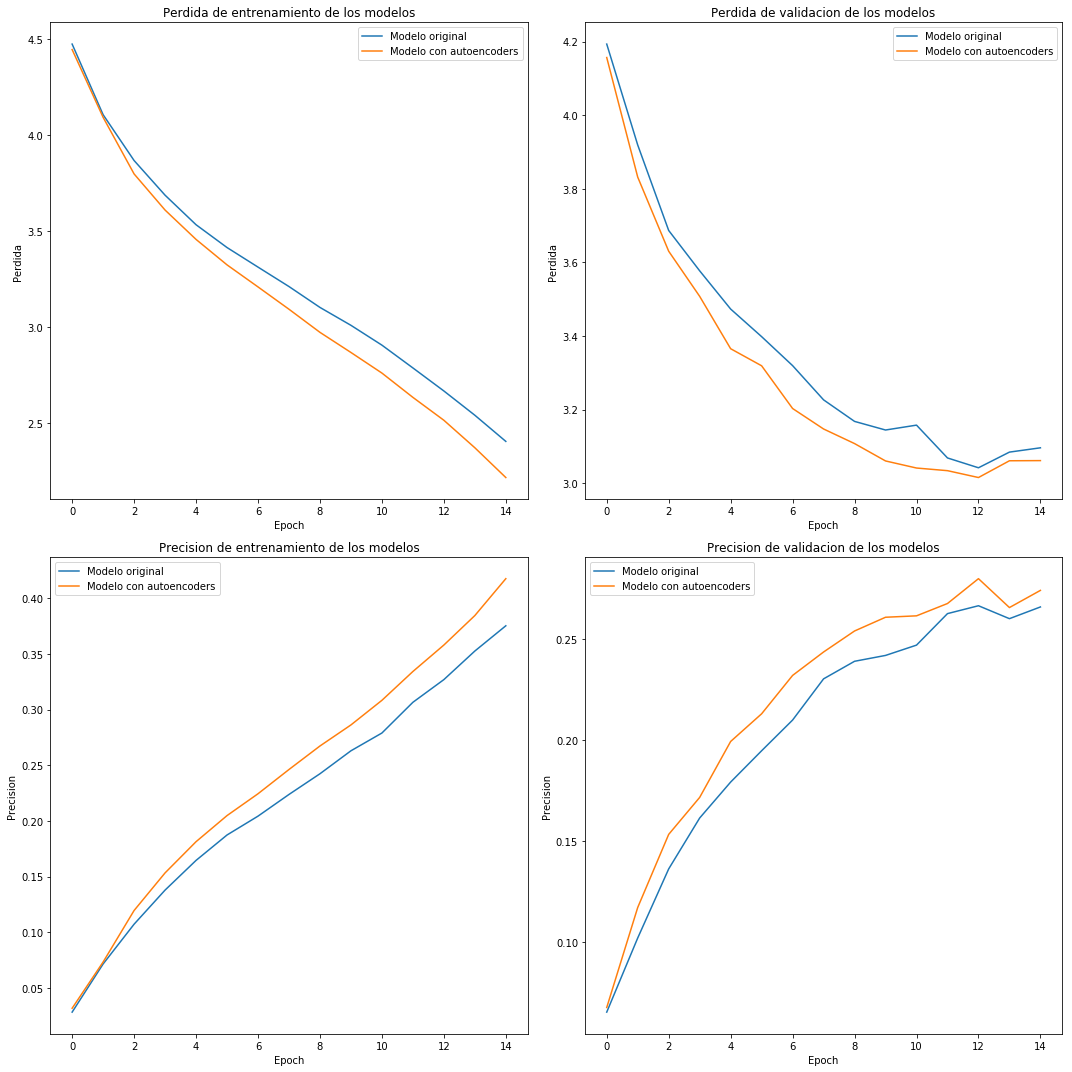

In [24]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(15,15))
ax = axes.flatten()
leg=['Modelo original','Modelo con autoencoders']
for i in range(2):
    ax[0].plot(historias[i].history['loss'][0:15])
    ax[1].plot(historias[i].history['val_loss'][0:15])
    ax[2].plot(historias[i].history['acc'][0:15])
    ax[3].plot(historias[i].history['val_acc'][0:15])
ax[0].set_title('Perdida de entrenamiento de los modelos')
ax[0].set_ylabel('Perdida')
ax[0].set_xlabel('Epoch')
ax[0].legend(leg, loc='upper right')
ax[1].set_title('Perdida de validacion de los modelos')
ax[1].set_ylabel('Perdida')
ax[1].set_xlabel('Epoch')
ax[1].legend(leg, loc='upper right')
ax[2].set_title('Precision de entrenamiento de los modelos')
ax[2].set_ylabel('Precision')
ax[2].set_xlabel('Epoch')
ax[2].legend(leg, loc='upper left')
ax[3].set_title('Precision de validacion de los modelos')
ax[3].set_ylabel('Precision')
ax[3].set_xlabel('Epoch')
ax[3].legend(leg, loc='upper left')
plt.tight_layout()
plt.show()

Comparando ambos modelos lado a lado, el modelo que usa autoencoders tiene mejor desempeño durante el entrenamiento y en el conjunto de validación, aunque de manera menos consistente en este último.

De esto se puede concluir que lo aprendido por los autoencoders individualmente, se ve reflejado en el modelo que los utiliza como capas intermedias.

Una explicación de la mejora en desempeño con los autoencoders es que al reconstruir las imágenes, son capaces de intensificar las características que la red neuronal es capaz de reconocer, acercando imágenes ambiguas a alguna de las clases del modelo.

Parte d)

VGG16 es un modelo incluido en Keras que consiste en 16 capas convolucionales de filtros pequeños. 

Primero preprocesamos las imágenes originales, pues VGG16 utiliza el formato BGR.

In [65]:
(x_train, _), (x_test, _) = cifar100.load_data(label_mode='fine')

In [67]:
x_train = x_train/255.0
x_test = x_test/255.0

In [45]:
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image

In [68]:
x_train2=preprocess_input(x_train)
x_test2=preprocess_input(x_test)

Luego evaluamos las imágenes en el modelo.

In [72]:
from keras.applications import VGG16
#LOAD PRETRAINED MODEL 
input_tensor=Input(shape=x_train.shape[1:])
modelVGG = VGG16(weights='imagenet', include_top=False,input_tensor=input_tensor )
features_train = modelVGG.predict(x_train2)
features_test = modelVGG.predict(x_test2)
modelVGG.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
__________

El conjunto de entrenamiento y de testeo son procesados por la red, dando como salida lo siguiente.

In [38]:
features_train.shape

(50000, 1, 1, 512)

En contraste con *x_train* que tenía dimensiones $5000\times 32 \times 32 \times 3$ para representar $5000$ imágenes de $32\times32$ con $3$ valores RGB, *feautures_train* filtra a lo largo de sus 16 capas features de la imagen original resultando en una salida de $1\times1\times512$ por imagen. Esto se puede interpretar como 512 canales de features por imágen, los cuáles indican la intensidad del feature.

Parte e)

Utilizando la salida de VGG16, entrenamos una red simple con dropout. Notar que esto es lo mismo que crear un gran modelo, negando el aprendizaje en la sección VGG16.

In [85]:
epochs_=10

In [86]:
model = Sequential()
model.add(Flatten(input_shape=features_train.shape[1:]))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(100))
model.add(Activation('softmax'))
optimizer_ = keras.optimizers.SGD(lr=0.01,momentum=0.9)
model.compile(optimizer=optimizer_,loss='categorical_crossentropy', metrics=['accuracy'])
start=timer()
hist=model.fit(features_train, y_train,epochs=epochs_, batch_size=128,verbose=0,validation_data=(features_test,y_test))
end = timer()
print("Tiempo de ejecución: {} seg".format(end - start))

Tiempo de ejecución: 10.750869970004715 seg


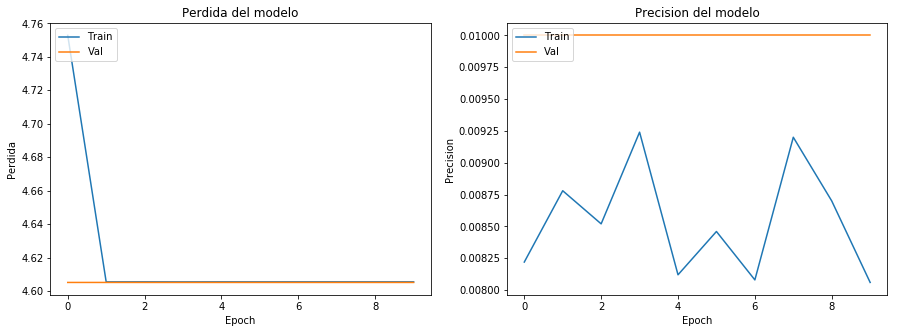

In [87]:
resumenGrafico(hist)

El tiempo es notablemente corto, pero aún más notorio es lo inconsistente que es el entrenamiento del modelo. Esto puede deberse a un problema de gradiente explosiva, lo cuál puede ser solucionado con un regularizador o utilizando *batch normalization*.

Parte f)

De la misma manera que la normalización del input a valores de 0 a 1 resulta en un aprendizaje acelerado, esto se puede aplicar a capas ocultas. *Batch normalization* reduce la cantidad en que unidades ocultas varían, evitando activaciones muy bajas o altas.

Entrenamos el modelo con las capas de normalización por 15 epochs.

In [108]:
epochs_=15

In [109]:
model = Sequential()
model.add(Flatten(input_shape=features_train.shape[1:]))
model.add(BatchNormalization())
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(100))
model.add(Activation('softmax'))
model.compile(optimizer=optimizer_,loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_14 (Flatten)         (None, 512)               0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 512)               2048      
_________________________________________________________________
dense_27 (Dense)             (None, 1024)              525312    
_________________________________________________________________
batch_normalization_7 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_14 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 100)               102500    
_________________________________________________________________
activation_14 (Activation)   (None, 100)               0         
Total para

In [110]:
start=timer()
histo=model.fit(features_train, y_train,epochs=epochs_, batch_size=128,verbose=0,validation_data=(features_test,y_test))
end = timer()
print("Tiempo de ejecución: {} seg".format(end - start))

Tiempo de ejecución: 23.427868940001645 seg


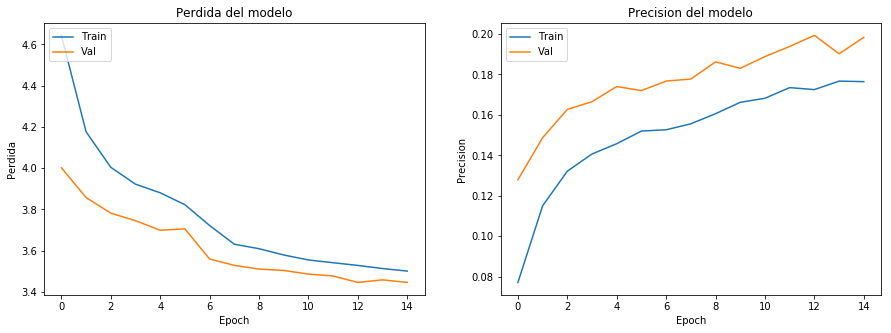

In [111]:
resumenGrafico(histo)

Como se puede observar, se ha solucionado el problema de gradiente explosiva. Además este modelo logra un excelente desempeño, obteniendo una precisión en validación incluso mayor que durante el entrenamiento.

Se procede a comparar este modelo con el que utilizó autoencoders y el original.

In [112]:
historias=[]
historias.append(historia1)
historias.append(historia2)
historias.append(histo)

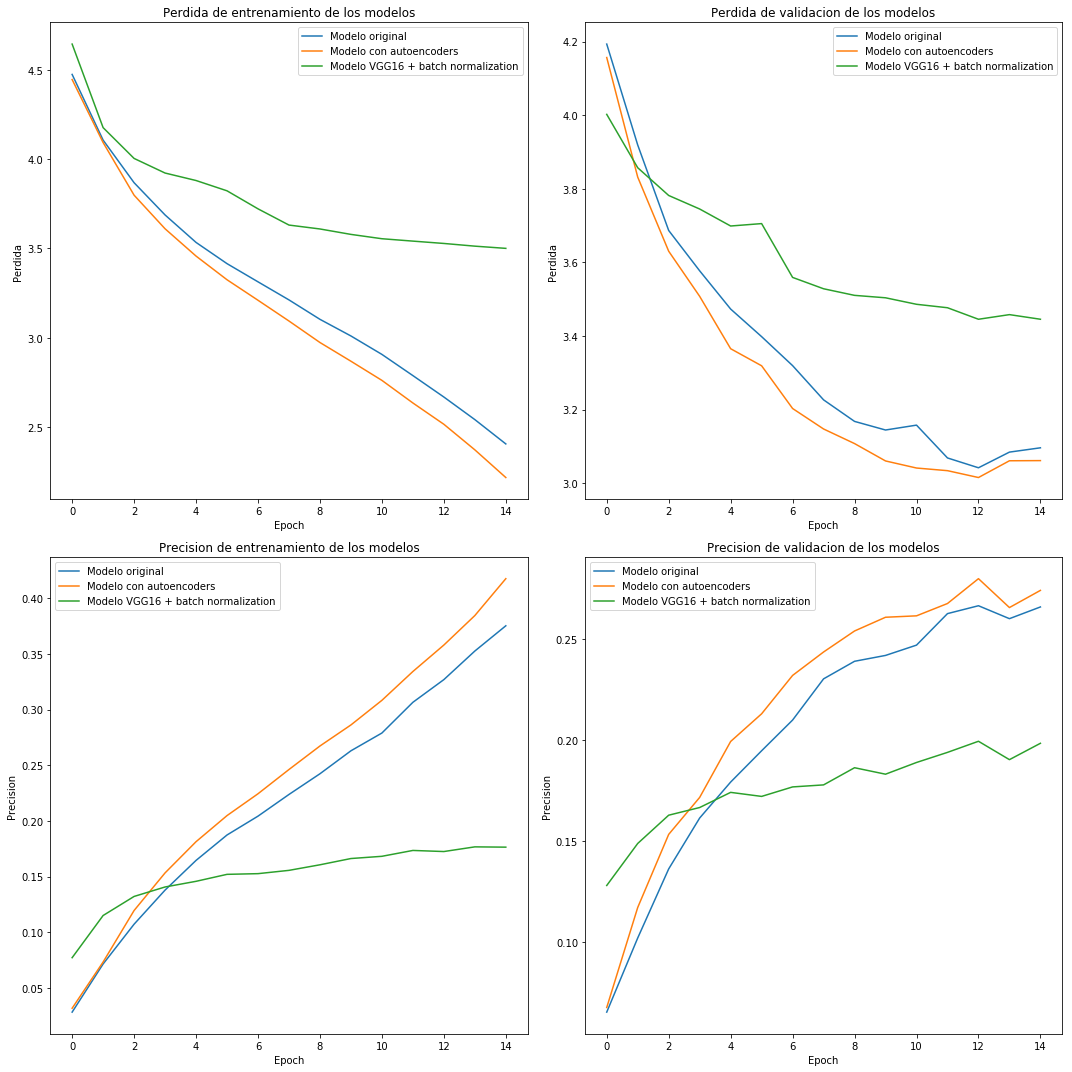

In [114]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(15,15))
ax = axes.flatten()
leg=['Modelo original','Modelo con autoencoders','Modelo VGG16 + batch normalization']
for i in range(3):
    ax[0].plot(historias[i].history['loss'])
    ax[1].plot(historias[i].history['val_loss'])
    ax[2].plot(historias[i].history['acc'])
    ax[3].plot(historias[i].history['val_acc'])
ax[0].set_title('Perdida de entrenamiento de los modelos')
ax[0].set_ylabel('Perdida')
ax[0].set_xlabel('Epoch')
ax[0].legend(leg, loc='upper right')
ax[1].set_title('Perdida de validacion de los modelos')
ax[1].set_ylabel('Perdida')
ax[1].set_xlabel('Epoch')
ax[1].legend(leg, loc='upper right')
ax[2].set_title('Precision de entrenamiento de los modelos')
ax[2].set_ylabel('Precision')
ax[2].set_xlabel('Epoch')
ax[2].legend(leg, loc='upper left')
ax[3].set_title('Precision de validacion de los modelos')
ax[3].set_ylabel('Precision')
ax[3].set_xlabel('Epoch')
ax[3].legend(leg, loc='upper left')
plt.tight_layout()
plt.show()

Los dos últimos modelos entrenados poseen resultados muy similares, ambos superando al original por un amplio margen. Se puede apreciar también que la red que utilizó los autoencoders tiene marginalmente mejor desempeño que la última entrenada, por lo que se puede concluir que utilizando *transfer learning* el beneficio está en el tiempo reducido para entrenar estas redes, al costo de obtener una red menos especializada.

Se destaca esto último, pues en el caso de tener un conjunto de entrenamiento suficientemente grande para la tarea a la mano (como clasificar imágenes en un número distinto de clases) se podría obtener un mejor desempeño, sin embargo la posibilidad de tener a mano este set de datos es una dificultad que puede ser sorteada con *transfer learning*.

Parte g)

El ejemplo que entrega el enunciado permite el entrenamiento de las últimas 4 capas.

In [127]:
#LOAD PRETRAINED MODEL 
input_tensor=Input(shape=x_train.shape[1:])
modelVGG = VGG16(weights='imagenet', include_top=False,input_tensor=input_tensor )
salida_vgg = modelVGG.get_layer('block4_pool').output_shape
model = Sequential()
model.add(Conv2D(512,(3, 3),input_shape=salida_vgg[1:],activation='relu',padding='same'))
model.add(Conv2D(512,(3, 3),activation='relu',padding='same'))
model.add(Conv2D(512,(3, 3),activation='relu',padding='same'))
model.add(MaxPooling2D((2, 2),strides=(2,2)))    
##dense section
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(100, activation='softmax'))
#delete last 4 layers of VGG16 and transfer the weight to new model
modelVGG.layers.pop() #delete last maxpooling
for i in np.arange(2,-1,-1):
    last = modelVGG.layers.pop() #delete convolutional layers
    model.layers[i].set_weights(last.get_weights())
from keras.models import Model
crop_modelVGG = Model(inputs=modelVGG.input, outputs=modelVGG.layers[-1].output)
#Se vuelve a preprocesar el input
x_train2=preprocess_input(x_train)
x_test2=preprocess_input(x_test)
features_train = crop_modelVGG.predict(x_train2)
features_test = crop_modelVGG.predict(x_test2)
#train it
optimizer_ = keras.optimizers.SGD(lr=0.01,momentum=0.9)
model.compile(optimizer=optimizer_,loss='categorical_crossentropy', metrics=['accuracy'])
start=timer()
hist_f=model.fit(features_train,y_train,epochs=15,batch_size=128,verbose=0,validation_data=(features_test,y_test))
end = timer()
print("Tiempo de ejecución: {} seg".format(end - start))

Tiempo de ejecución: 244.0874334839973 seg


Al permitir que las últimas 4 capas de VGG16 sean entrenables (es decir, la última tanda de capas convolucionales) se agregan aproximadamente 7 millones de parámetros que pueden ser modificados, aumentando sustancialmente el tiempo de ejecución del algoritmo.

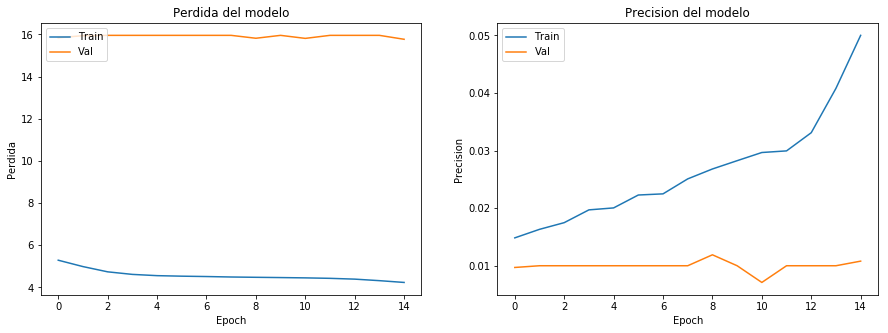

In [128]:
resumenGrafico(hist_f)

El entrenamiento no parece mejorar la pérdida o precisión en el conjunto de validación, lo cuál puede deberse a over-fitting desde el primer epoch. Una posible causa es que como VGG16 ya está previamente entrenado, hacer cambios posteriores no mejorará el desempeño real de la red.

De lo anterior se infiere que conviene permitir modificaciones solamente en las capas no entrenadas, donde sí puede haber aprendizaje.

In [129]:
historias=[]
historias.append(histo)
historias.append(hist_f)

A modo de verificación, se compara el entrenamiento con el modelo anterior.

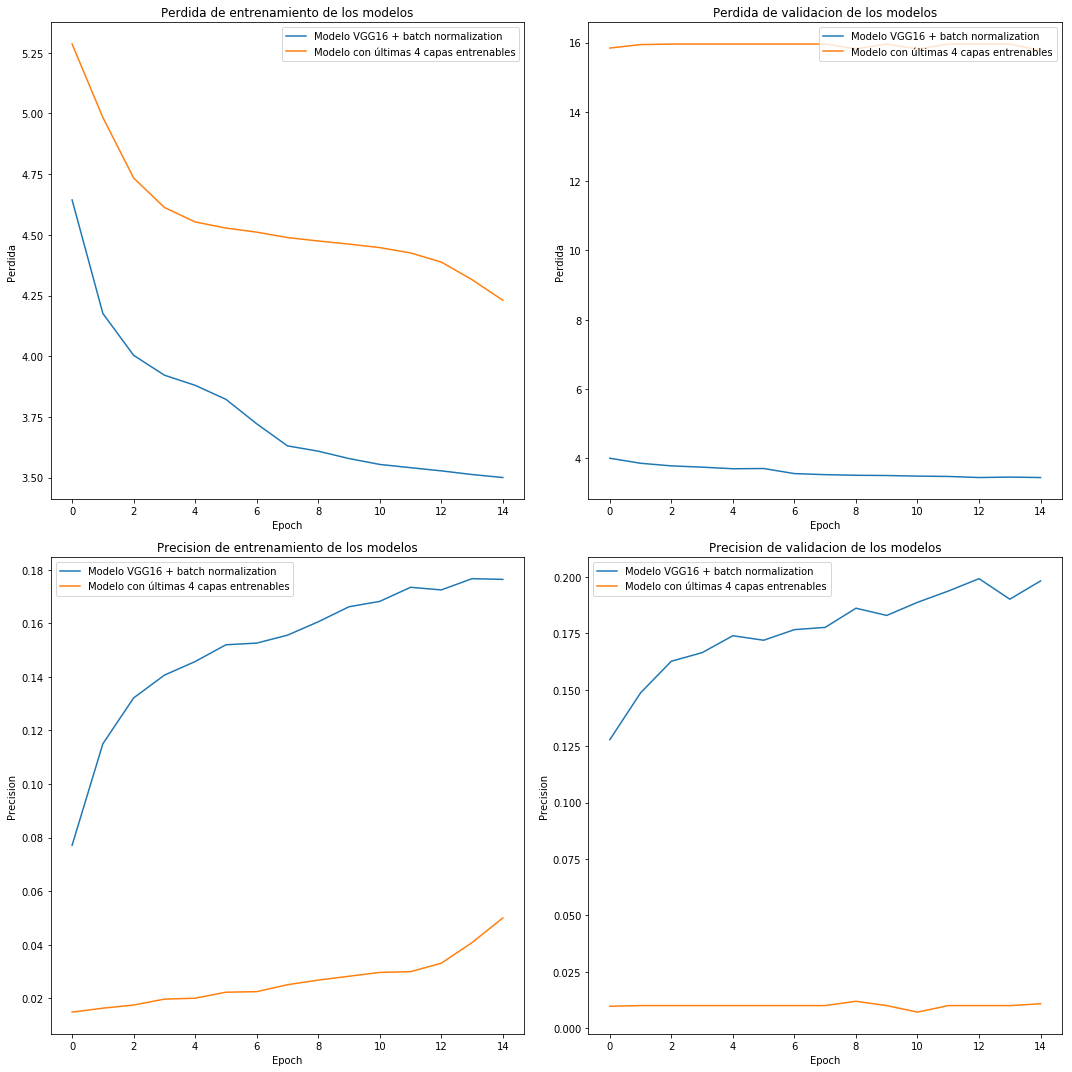

In [130]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(15,15))
ax = axes.flatten()
leg=['Modelo VGG16 + batch normalization','Modelo con últimas 4 capas entrenables']
for i in range(2):
    ax[0].plot(historias[i].history['loss'])
    ax[1].plot(historias[i].history['val_loss'])
    ax[2].plot(historias[i].history['acc'])
    ax[3].plot(historias[i].history['val_acc'])
ax[0].set_title('Perdida de entrenamiento de los modelos')
ax[0].set_ylabel('Perdida')
ax[0].set_xlabel('Epoch')
ax[0].legend(leg, loc='upper right')
ax[1].set_title('Perdida de validacion de los modelos')
ax[1].set_ylabel('Perdida')
ax[1].set_xlabel('Epoch')
ax[1].legend(leg, loc='upper right')
ax[2].set_title('Precision de entrenamiento de los modelos')
ax[2].set_ylabel('Precision')
ax[2].set_xlabel('Epoch')
ax[2].legend(leg, loc='upper left')
ax[3].set_title('Precision de validacion de los modelos')
ax[3].set_ylabel('Precision')
ax[3].set_xlabel('Epoch')
ax[3].legend(leg, loc='upper left')
plt.tight_layout()
plt.show()

El modelo anterior supera en todo aspecto a la red recién utilizada, reafirmando la idea de que entrenar con datos nuevos una red como VGG16, que de partida posee un amplio conocimiento, no se traduce en ningún beneficio.